In [43]:
!pip install matplotlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def sample_frames(video_path, num_frames):
    """
    Sample evenly spaced frames from a video file.

    Args:
        video_path (str): Path to the video file.
        num_frames (int): Number of frames to sample.

    Returns:
        list: List of sampled grayscale frames.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if num_frames > total_frames:
        num_frames = total_frames

    interval = total_frames / num_frames

    for i in range(num_frames):
        frame_idx = int(i * interval)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            if len(frame.shape) == 3:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
    cap.release()
    return frames

def detect_sift_features(frame):
    """
    Detect SIFT features in a grayscale frame.

    Args:
        frame (numpy.ndarray): Grayscale image.

    Returns:
        tuple: Keypoints and descriptors.
    """
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(frame, None)
    return keypoints, descriptors

def find_repeated_features(keypoints_list, descriptors_list, spatial_threshold=2.0):
    """
    Find repeated SIFT features across multiple frames.

    Args:
        keypoints_list (list): List of keypoints for each frame.
        descriptors_list (list): List of descriptors for each frame.
        spatial_threshold (float): Distance threshold to consider features as repeated.

    Returns:
        list: List of repeated feature points for each frame.
    """
    bf = cv2.BFMatcher()
    num_frames = len(keypoints_list)
    repeated_features = [[] for _ in range(num_frames)]
    feature_counts = defaultdict(int)

    for i in range(num_frames - 1):
        kp1 = keypoints_list[i]
        des1 = descriptors_list[i]
        for j in range(i + 1, num_frames):
            kp2 = keypoints_list[j]
            des2 = descriptors_list[j]

            if des1 is None or des2 is None:
                continue

            matches = bf.knnMatch(des1, des2, k=2)
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    pt1 = kp1[m.queryIdx].pt
                    pt2 = kp2[m.trainIdx].pt
                    distance = np.linalg.norm(np.array(pt1) - np.array(pt2))
                    if distance < spatial_threshold:
                        feature_counts[i, m.queryIdx] += 1
                        feature_counts[j, m.trainIdx] += 1

    # Threshold to keep features repeated in more than one frame
    for (frame_idx, kp_idx), count in feature_counts.items():
        if count > 1:
            pt = keypoints_list[frame_idx][kp_idx].pt
            repeated_features[frame_idx].append((int(pt[0]), int(pt[1])))

    # Remove duplicates
    for idx in range(num_frames):
        repeated_features[idx] = list(set(repeated_features[idx]))

    return repeated_features

def preprocess_for_contours(frame):
    """
    Preprocess the frame to enhance contour detection.

    Args:
        frame (numpy.ndarray): Grayscale image.

    Returns:
        numpy.ndarray: Preprocessed binary image.
    """
    # blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    # _, thresh = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, thresh = cv2.threshold(frame, 250, 255, cv2.THRESH_BINARY)
    # Invert if background is lighter
    if np.mean(thresh) > 127:
        thresh = cv2.bitwise_not(thresh)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    dilated = cv2.dilate(opened, kernel, iterations=1)

    return dilated

def get_contours(preprocessed_frame):
    """
    Find contours in the preprocessed frame.

    Args:
        preprocessed_frame (numpy.ndarray): Binary image for contour detection.

    Returns:
        list: Detected contours.
    """
    contours, _ = cv2.findContours(preprocessed_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def plot_image(image, title='Image', cmap='gray'):
    """
    Display an image using matplotlib.

    Args:
        image (numpy.ndarray): Image to display.
        title (str): Title of the plot.
        cmap (str): Color map to use.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def identify_contours_to_remove(repeated_features, contours):
    """
    Identify which contours contain any of the repeated feature points.

    Args:
        repeated_features (list): List of repeated feature points (tuples) in the first frame.
        contours (list): List of contours in the first frame.

    Returns:
        list: Indices of contours to remove.
    """
    contours_to_remove = set()
    for pt in repeated_features:
        for idx, contour in enumerate(contours):
            if cv2.pointPolygonTest(contour, pt, False) >= 0:
                contours_to_remove.add(idx)
                break
    return list(contours_to_remove)

def create_removal_mask(frame_shape, contours, contours_to_remove):
    """
    Create a mask to remove specified contours.

    Args:
        frame_shape (tuple): Shape of the frame (height, width).
        contours (list): List of contours.
        contours_to_remove (list): Indices of contours to remove.

    Returns:
        numpy.ndarray: Mask with contours to remove filled with 255.
    """
    mask = np.zeros(frame_shape, dtype=np.uint8)
    for idx in contours_to_remove:
        cv2.drawContours(mask, [contours[idx]], -1, 255, -1)
    return mask

def apply_mask_to_frames(frames, mask):
    """
    Apply the removal mask to all frames.

    Args:
        frames (list): List of grayscale frames.
        mask (numpy.ndarray): Mask indicating areas to remove.

    Returns:
        list: List of processed frames with specified areas removed.
    """
    processed = []
    for frame in frames:
        frame_copy = frame.copy()
        frame_copy[mask == 255] = 255
        processed.append(frame_copy)
    return processed

# Example Usage in Jupyter Notebook
# ---------------------------------
# Run each cell separately to debug

# 1. Sample Frames
# frames = sample_frames('temp_image_processing/Worm3.avi', num_frames=5)
# plot_image(frames[0], title='Sampled Frame 0')

# 2. Detect SIFT Features
# keypoints_list = []
# descriptors_list = []
# for idx, frame in enumerate(frames):
#     kp, des = detect_sift_features(frame)
#     keypoints_list.append(kp)
#     descriptors_list.append(des)
#     print(f"Frame {idx}: {len(kp)} keypoints detected")

# 3. Find Repeated Features
# repeated_features = find_repeated_features(keypoints_list, descriptors_list, spatial_threshold=2.0)
# print(f"Repeated features per frame: {repeated_features}")

# 4. Preprocess First Frame for Contours
# preprocessed = preprocess_for_contours(frames[0])
# plot_image(preprocessed, title='Preprocessed Frame 0')

# 5. Get Contours from First Frame
# contours = get_contours(preprocessed)
# frame_with_contours = cv2.cvtColor(frames[0], cv2.COLOR_GRAY2BGR)
# cv2.drawContours(frame_with_contours, contours, -1, (0, 255, 0), 1)
# plot_image(frame_with_contours, title='Contours on Frame 0')

# 6. Identify Contours to Remove Based on Repeated Features in First Frame
# contours_to_remove = identify_contours_to_remove(repeated_features[0], contours)
# print(f"Contours to remove: {contours_to_remove}")

# 7. Create Removal Mask
# mask = create_removal_mask(frames[0].shape, contours, contours_to_remove)
# plot_image(mask, title='Removal Mask')

# 8. Apply Mask to All Frames
# processed_frames = apply_mask_to_frames(frames, mask)
# for idx, frame in enumerate(processed_frames):
#     plot_image(frame, title=f'Processed Frame {idx}')

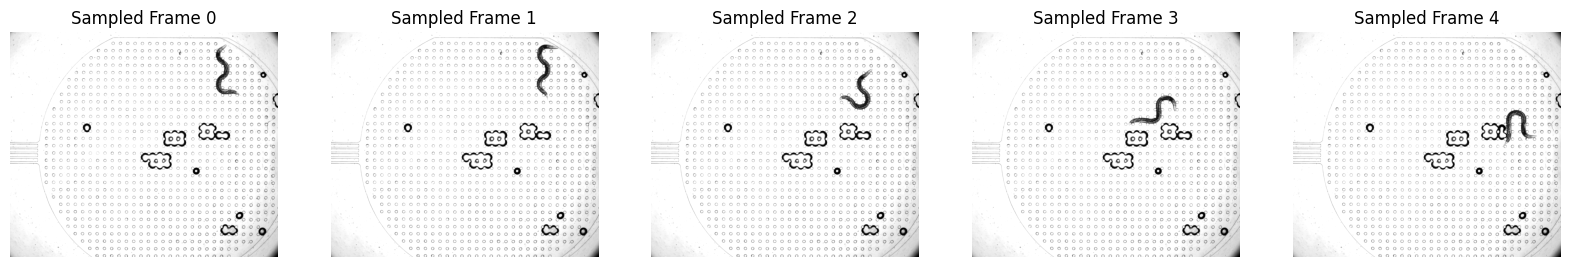

In [21]:
frames = sample_frames('Worm3.avi', num_frames=5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, frame in enumerate(frames):
    axes[idx].imshow(frame, cmap='gray')
    axes[idx].set_title(f'Sampled Frame {idx}')
    axes[idx].axis('off')
plt.show()

In [22]:
keypoints_list = []
descriptors_list = []
for idx, frame in enumerate(frames):
    kp, des = detect_sift_features(frame)
    keypoints_list.append(kp)
    descriptors_list.append(des)
    print(f"Frame {idx}: {len(kp)} keypoints detected")

Frame 0: 9233 keypoints detected
Frame 1: 9331 keypoints detected
Frame 2: 9148 keypoints detected
Frame 3: 9340 keypoints detected
Frame 4: 9361 keypoints detected


In [25]:
repeated_features = find_repeated_features(keypoints_list, descriptors_list, spatial_threshold=2.0)
for idx, features in enumerate(repeated_features):
    print(f"Frame {idx}: {len(features)} repeated features")

Frame 0: 4453 repeated features
Frame 1: 4626 repeated features
Frame 2: 4577 repeated features
Frame 3: 4531 repeated features
Frame 4: 4468 repeated features


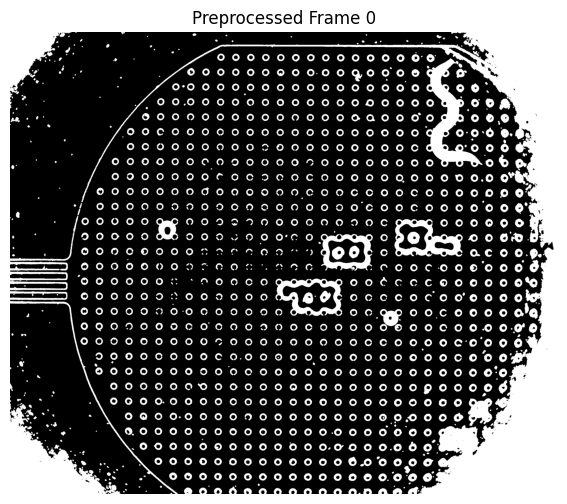

In [44]:
preprocessed = preprocess_for_contours(frames[0])
plot_image(preprocessed, title='Preprocessed Frame 0')

In [45]:
contours = get_contours(preprocessed)
print(f"Total contours detected in Frame 0: {len(contours)}")

Total contours detected in Frame 0: 1117


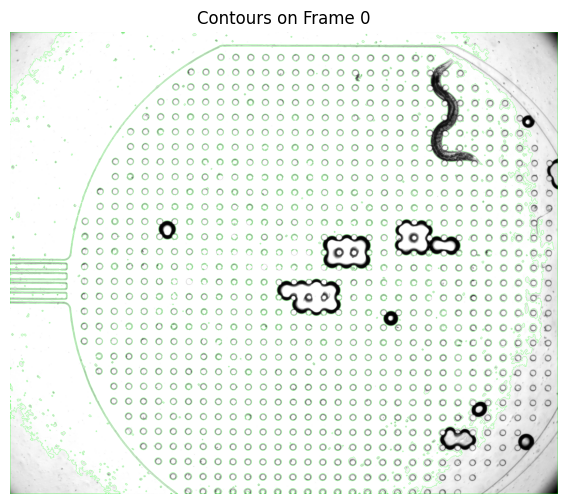

In [46]:
frame_with_contours = cv2.cvtColor(frames[0], cv2.COLOR_GRAY2BGR)
cv2.drawContours(frame_with_contours, contours, -1, (0, 255, 0), 1)
plot_image(frame_with_contours, title='Contours on Frame 0')